In [257]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(f' ------------- \n',
      f'Versions: \n',
      f'------------- \n'
      f' numpy=={np.__version__} \n'
     )

 ------------- 
 Versions: 
 ------------- 
 numpy==1.22.1 



## Reference Values:

In [258]:
h_ref = 1e-2
rho_ref = 5e3
lambda_ref = 2.5e3**2*rho_ref
c_ref = np.sqrt(lambda_ref/rho_ref)

## Material Properties

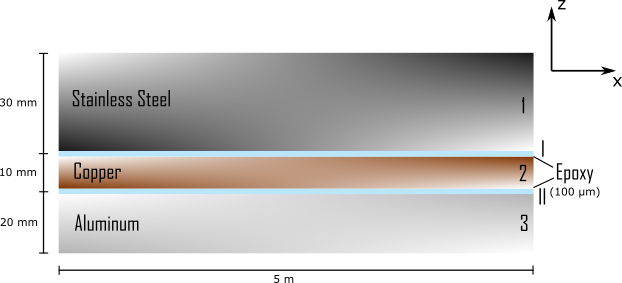

> Importing mode parameters:

In [259]:
interface_of_interest = 'copper-stainless steel'
direction_of_interest = 'xx'

def load_mode_parameters():
    with open(f'./results/modes_parameters/kx_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        kx_mode = pickle.load(fp)
    with open(f'./results/modes_parameters/freq_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        freq_mode = 1000*pickle.load(fp)
    with open(f'./results/modes_parameters/deltaU_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        deltaU = pickle.load(fp)
    with open(f'./results/modes_parameters/u_1_spec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        u_1_spec = pickle.load(fp)
    with open(f'./results/modes_parameters/u_2_spec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        u_2_spec = pickle.load(fp)
    with open(f'./results/modes_parameters/x_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        x = pickle.load(fp)
    with open(f'./results/modes_parameters/kx_vec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        kx_vec = pickle.load(fp)
        
    return kx_mode, freq_mode, deltaU, u_1_spec, u_2_spec, x, kx_vec

kx_mode, freq_mode, deltaU, u_1_spec, u_2_spec, x, kx = load_mode_parameters()

nkx = len(kx)
omega = freq_mode*2*np.pi*h_ref/c_ref
x_dimensionless = x/h_ref
nx = len(x)

- ### Layer 1 (Aluminum):

In [260]:
rho_1 = 2700/rho_ref
vp_1 = 6320/c_ref
vs_1 = 3130/c_ref
mu_1 = vs_1**2*rho_1
lambda_1 = vp_1**2*rho_1-2*mu_1
h_1 = 2e-2/h_ref

- ### Layer 2 (Copper):

In [261]:
rho_2 = 8930/rho_ref
vp_2 = 4660/c_ref
vs_2 = 2660/c_ref
mu_2 = vs_2**2*rho_2
lambda_2 = vp_2**2*rho_2-2*mu_2
h_2 = 1e-2/h_ref

- ### Layer 3 (Stainless Steel):

In [262]:
rho_3 = 7900/rho_ref
vp_3 = 5790/c_ref
vs_3 = 3100/c_ref
mu_3 = vs_3**2*rho_3
lambda_3 = vp_3**2*rho_3-2*mu_3
h_3 = 3e-2/h_ref

- ### Interfaces:

> ##### Interface II (Layers 1-2)

In [263]:
h_interface_2 = 100e-6/h_ref
vp_interface_2 = 2150/c_ref
vs_interface_2 = 1030/c_ref
rho_interface_2 = 1200/rho_ref

> ##### Interface III (Layers 2-3)

In [264]:
h_interface_3 = 100e-6/h_ref
vp_interface_3 = 2150/c_ref
vs_interface_3 = 1030/c_ref
rho_interface_3 = 1200/rho_ref

> ##### Computing specular stiffness (QSA):

In [265]:
def computeSpecularStiffness(thickness, rho, P_speed, S_speed):
    mu = (S_speed**2)*rho
    lamb = (P_speed**2)*rho-2*mu
    s = 1/mu
    c = 2*mu+lamb
    K_specular = np.linalg.inv(thickness*np.array([[s, 0, 0], [0, s, 0], [0, 0, 1/c]]))
    return K_specular

> ##### Generating Defects:

In [266]:
defect_dict = {'xx': 0, 'yy': 1, 'zz': 2}

def randomFieldDefect(
    x,
    correlation_length,
    stdev,
    number_of_samples,
    mean_random_field=0,
    field_type = 'gaussian'
):

    n_elements = len(x)
    if field_type == 'gaussian':
        covariance_field = lambda r, s :stdev ** 2 * np.exp(-1 * ((r - s) / correlation_length) ** 2)
    elif field_type == 'exponential':
        covariance_field = lambda r, s : stdev ** 2 * np.exp(-1 * abs(r - s) / correlation_length)
    else:
        return print('error - field type not found')
    covariance_matrix = np.zeros((n_elements, n_elements))
    for ii in range(0, n_elements):
        for jj in range(ii, n_elements):
            covariance_matrix[ii, jj] = covariance_field(x[ii], x[jj])
    covariance_matrix = (covariance_matrix + covariance_matrix.T) - np.diag(np.diag(covariance_matrix))
    xi = np.random.randn(n_elements, number_of_samples)
    muY = mean_random_field * np.ones((n_elements, number_of_samples))
    Ag, Ug = np.linalg.eig(covariance_matrix)
    Ag = np.diag(Ag)
    Vg = np.dot(Ug, np.real(np.sqrt(Ag, dtype = complex)))
    random_field = muY + np.dot(Vg, xi)
    random_field_transformed = np.tanh(np.exp(-random_field))
    for ii in range(0, number_of_samples):
        random_field_transformed[:, ii] = (random_field_transformed[:, ii] - max(random_field_transformed[:, ii]))
    # filter to avoid having defects at the edges:
    filter_center = (x[0] + x[-1])/2
    filter_sigma = x[-1]/12
    filter_offset = x[-1] - x[-1]/6.5*(x[-1] - x[0])
    field_filter = np.zeros(x.shape)
    for ii in range(0, len(x)):
        field_filter[ii] = np.exp(- np.max([0, abs(x[ii] - filter_center) - filter_offset]) / (2 * filter_sigma ** 2))
    damage_field = np.zeros(random_field.shape)
    damage_field_transformed = np.zeros(random_field.shape)
    for ii in range(len(x)):
        damage_field_transformed[ii, :] = field_filter[ii] * random_field_transformed[ii, :] + 1
        damage_field[ii, :] = field_filter[ii] * random_field[ii, :]
    return damage_field, damage_field_transformed, covariance_matrix

def gaussianDefect(x, magnitude, mean = None, stdev = None):
    if mean is None:
        mean = (max(x) + min(x))/2
    if stdev is None:
        stdev = max(x)/100
    if stdev == 0:
        gaussian = np.zeros((len(x),)) + 1
        return gaussian

    gaussian = 1 - magnitude * np.exp(-((x - mean) / stdev) ** 2)
    return gaussian

def rectangularDefect(x, magnitude, x_min = None, x_max = None):
    if x_min is None:
        x_min = min(x)
    if x_max is None:
        x_max = max(x)
    rectangular = []
    for ii in x:
        if ii < x_min:
            rectangular.append(0)
        elif ii >= x_min and ii <= x_max:
            rectangular.append(magnitude)
        else:
            rectangular.append(0)
    rectangular = np.array(rectangular)
    rectangular = 1 - rectangular
                
    return rectangular

> #### Defects Examples:

C:\Users\berna\AppData\Local\Temp\ipykernel_3924\1286648138.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  damage_field_transformed[ii, :] = field_filter[ii] * random_field_transformed[ii, :] + 1
C:\Users\berna\AppData\Local\Temp\ipykernel_3924\1286648138.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  damage_field[ii, :] = field_filter[ii] * random_field[ii, :]


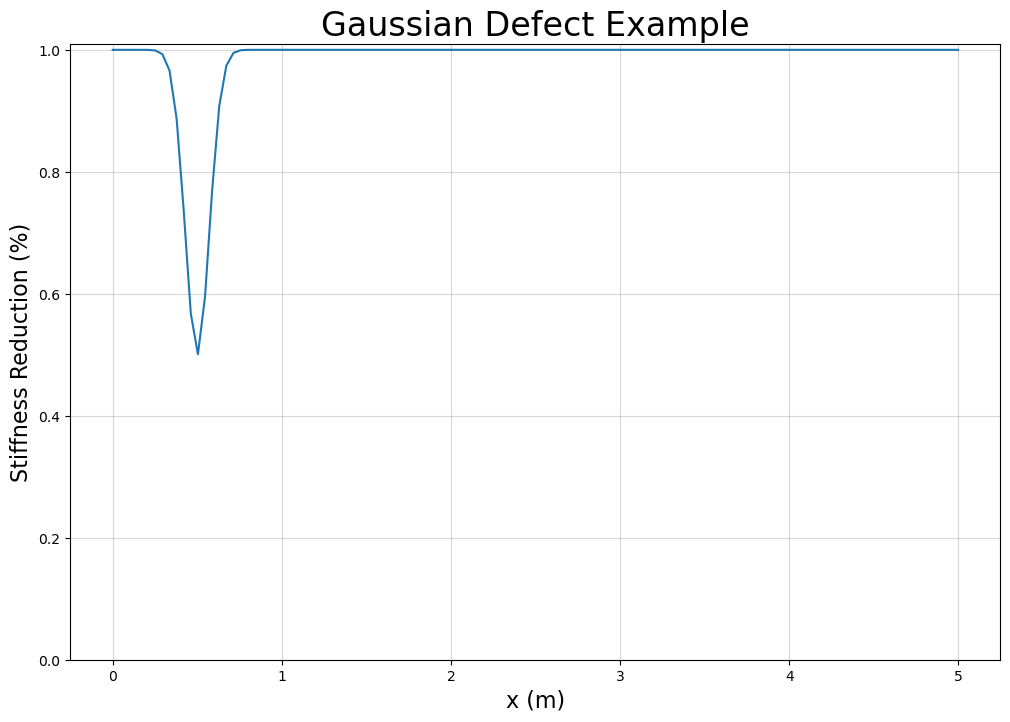

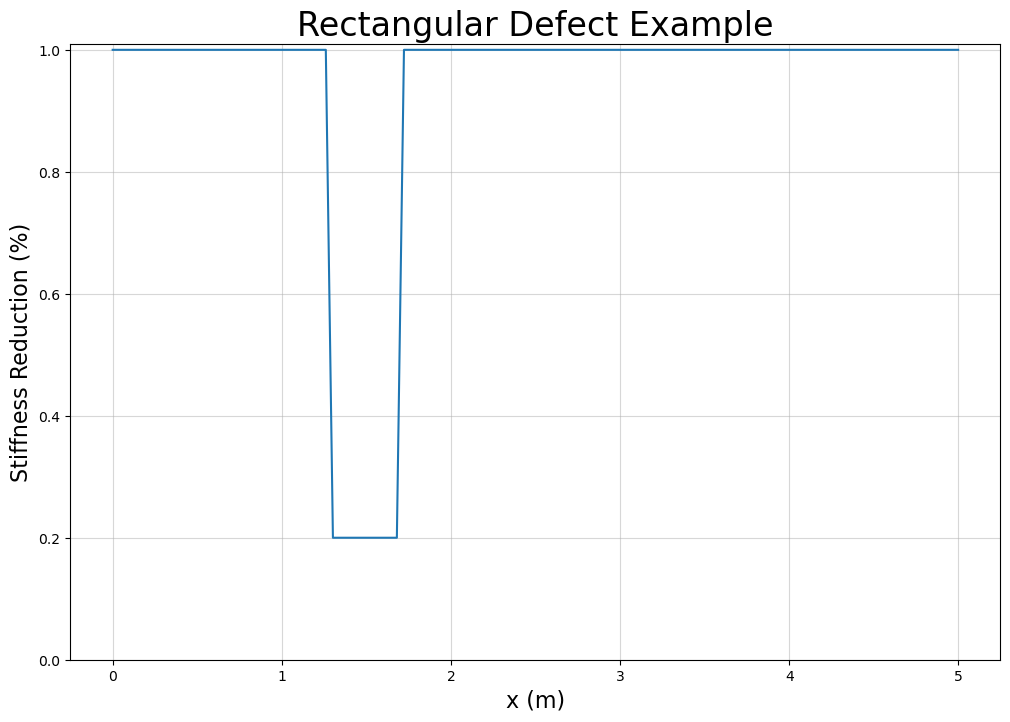

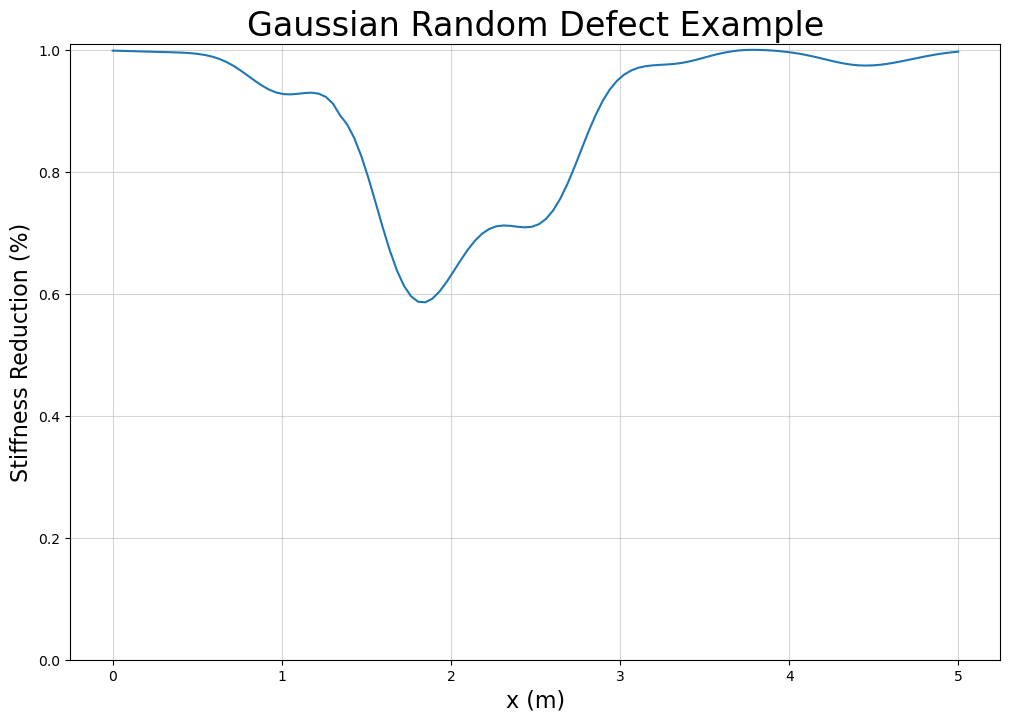

In [267]:
gauss_defect = gaussianDefect(x, magnitude=0.5, mean = 0.5, stdev = 0.1)
rectangular_defect = rectangularDefect(x, magnitude=0.8, x_min = 1.3, x_max = 1.7)
random_field, random_defect, cov_matrix = randomFieldDefect(
    x,
    correlation_length=0.56,
    stdev=0.8,
    number_of_samples=1,
    mean_random_field=0,
    field_type = 'gaussian'
)

plt.figure(figsize = (12,8))
plt.plot(x, gauss_defect)
plt.ylim([0, 1.01])
plt.grid(alpha=0.5)
plt.title('Gaussian Defect Example', size=24)
plt.ylabel('Stiffness Reduction (%)', size=16)
plt.xlabel('x (m)', size=16)
plt.show()

plt.figure(figsize = (12,8))
plt.plot(x, rectangular_defect)
plt.ylim([0, 1.01])
plt.grid(alpha=0.5)
plt.title('Rectangular Defect Example', size=24)
plt.ylabel('Stiffness Reduction (%)', size=16)
plt.xlabel('x (m)', size=16)
plt.show()

plt.figure(figsize = (12,8))
plt.plot(x, random_defect)
plt.ylim([0, 1.01])
plt.grid(alpha=0.5)
plt.title('Gaussian Random Defect Example', size=24)
plt.ylabel('Stiffness Reduction (%)', size=16)
plt.xlabel('x (m)', size=16)
plt.show()

- ### Computing acoustic tensors:

In [268]:
def computePropagationMatrices(kx, kp, kt, h_up, h_down):
    
    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)
    
    gamma_up = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_up,
        [np.exp(1j*kp_z*h_up),
         np.exp(1j*kt_z*h_up),
         np.exp(1j*kt_z*h_up)]
    )
    gamma_down = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_down,
        [np.exp(-1j*kp_z*h_down),
         np.exp(-1j*kt_z*h_down),
         np.exp(-1j*kt_z*h_down)]
    )

    A_up = np.array(
        [[kx/kp, -kt_z/kt, 0],
         [0, 0, 1],
         [kp_z/kp, kx/kt, 0]]
    )
    A_down = np.array(
        [[kx/kp, kt_z/kt, 0],
         [0, 0, 1],
         [-kp_z/kp, kx/kt, 0]]
    )

    M_up = np.dot(np.dot(A_up, gamma_up), np.linalg.inv(A_up))
    M_down = np.dot(np.dot(A_down, gamma_down), np.linalg.inv(A_down))

    return M_up, M_down


########################################################################################


def computeImpedances(omega, kx, kp, kt, lambda_, mu):

    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)

    A_aux_up = np.array([[kx, kp_z], [kt_z, -kx]], dtype=complex)
    A_aux_down = np.array([[-kx, kp_z], [kt_z, kx]], dtype=complex)

    C1_up = np.array(
        [[-2*mu*kp_z*kx/omega], [(mu/omega)*(kx**2-kt_z**2)]],
        dtype = complex
    )
    C2_up = np.array(
        [[-(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )
    C1_down = np.array(
        [[-2*mu*kp_z*kx/omega], [-(mu/omega)*(kx**2-kt_z**2)]],
        dtype=complex
    )
    C2_down = np.array(
        [[(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )

    z_11_up_z_13_up = np.dot(np.linalg.inv(A_aux_up), C1_up)
    z_11_up = z_11_up_z_13_up[0]
    z_13_up = z_11_up_z_13_up[1]
    z_12_up = 0
    z_21_up = 0
    z_22_up = -mu*kt_z/omega
    z_23_up = 0
    z_32_up = 0
    z_31_up_z_33_up = np.dot(np.linalg.inv(A_aux_up), C2_up)
    z_31_up = z_31_up_z_33_up[0]
    z_33_up = z_31_up_z_33_up[1]

    z_11_down_z_13_down = np.dot(np.linalg.inv(A_aux_down), C1_down)
    z_11_down = z_11_down_z_13_down[0]
    z_13_down = z_11_down_z_13_down[1]
    z_12_down = 0
    z_21_down = 0
    z_22_down = mu*kt_z/omega
    z_23_down = 0
    z_32_down = 0
    z_31_down_z_33_down = np.dot(np.linalg.inv(A_aux_down), C2_down)
    z_31_down = z_31_down_z_33_down[0]
    z_33_down = z_31_down_z_33_down[1]

    Z_up = np.array(
        [[z_11_up, z_12_up, z_13_up],
         [z_21_up, z_22_up, z_23_up],
         [z_31_up, z_32_up, z_33_up]],
        dtype=complex
    )

    Z_down = np.array(
        [[z_11_down, z_12_down, z_13_down],
         [z_21_down, z_22_down, z_23_down],
         [z_31_down, z_32_down, z_33_down]],
        dtype=complex
    )

    return Z_up, Z_down

## Solving the Acoustic Scattering Problem (step by step) 

\
PS: In this case we are sweeping the structure from top to bottom, i.e., from layer 3 to layer 1

0. #### Some Preparations:

> Computing $k_x$ from the discretized dimensionless x

In [269]:
#dx = x_dimensionless[1]-x_dimensionless[0]
#kx_max = 1/(2*dx)
#dkx = kx_max/(nx/2)
#kx_plus = np.arange(0, kx_max, dkx)
#kx_minus = np.arange(-kx_max, 0, dkx)
#kx = np.append(kx_minus, kx_plus)*2*np.pi
#nkx = len(kx)

> Computing the Acoustic Tensors

In [270]:
# Layer 1:

Z_up_1 = np.zeros((3, 3, nkx), dtype = complex)
Z_down_1 = np.zeros((3, 3, nkx), dtype = complex)
M_up_1 = np.zeros((3, 3, nkx), dtype = complex)
M_down_1 = np.zeros((3, 3, nkx), dtype = complex)
kp_1 = omega/vp_1
kt_1 = omega/vs_1

# Layer 2:

Z_up_2 = np.zeros((3, 3, nkx), dtype = complex)
Z_down_2 = np.zeros((3, 3, nkx), dtype = complex)
M_up_2 = np.zeros((3, 3, nkx), dtype = complex)
M_down_2 = np.zeros((3, 3, nkx), dtype = complex)
kp_2 = omega/vp_2
kt_2 = omega/vs_2

# Layer 3:

Z_up_3 = np.zeros((3, 3, nkx), dtype = complex)
Z_down_3 = np.zeros((3, 3, nkx), dtype = complex)
M_up_3 = np.zeros((3, 3, nkx), dtype = complex)
M_down_3 = np.zeros((3, 3, nkx), dtype = complex)
kp_3 = omega/vp_3
kt_3 = omega/vs_3

for ii in range(nkx):

    Z_up_1[:, :, ii], Z_down_1[:, :, ii] = computeImpedances(omega, kx[ii], kp_1, kt_1, lambda_1, mu_1)
    M_up_1[:, :, ii], M_down_1[:, :, ii] = computePropagationMatrices(kx[ii], kp_1, kt_1, -h_1, -h_1)

    Z_up_2[:, :, ii], Z_down_2[:, :, ii] = computeImpedances(omega, kx[ii], kp_2, kt_2, lambda_2, mu_2)
    M_up_2[:, :, ii], M_down_2[:, :, ii] = computePropagationMatrices(kx[ii], kp_2, kt_2, -h_2, -h_2)

    Z_up_3[:, :, ii], Z_down_3[:, :, ii] = computeImpedances(omega, kx[ii], kp_3, kt_3, lambda_3, mu_3)
    M_up_3[:, :, ii], M_down_3[:, :, ii] = computePropagationMatrices(kx[ii], kp_3, kt_3, -h_3, -h_3)

C:\Users\berna\AppData\Local\Temp\ipykernel_3924\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_3924\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


> Computing the Interfacial Stiffness Matrices

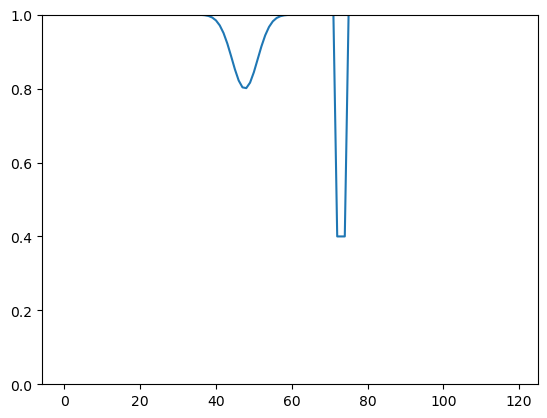

In [297]:
interfaces_dict = {
    'aluminum-copper':0,
    'copper-stainless steel':1 
}

Kspec_2 = computeSpecularStiffness(h_interface_2, rho_interface_2, vp_interface_2, vs_interface_2)
Kspec_3 = computeSpecularStiffness(h_interface_3, rho_interface_3, vp_interface_3, vs_interface_3)
damage1 = gaussianDefect(x, magnitude=0.2, mean = 2, stdev = 0.2)
damage2 = rectangularDefect(x, magnitude=0.6, x_min = 3, x_max = 3.15)
damage = damage1 + damage2 - 1
#random_field, damage, cov_matrix = randomFieldDefect(
#    x,
#    correlation_length=0.56,
#    stdev=0.8,
#    number_of_samples=1,
#    mean_random_field=0,
#    field_type = 'gaussian'
#)
damage = damage.reshape((x.shape[0],))

plt.plot(damage)
plt.ylim([0, 1])

def computeScatteredStiffness():
    Kspec = [Kspec_2, Kspec_3]
    Kscat_2 = np.zeros((3, 3, nx))
    Kscat_3 = np.zeros((3, 3, nx))
    Kscat = [Kscat_2, Kscat_3]
    Kscat[interfaces_dict[interface_of_interest]][
        defect_dict[direction_of_interest],
        defect_dict[direction_of_interest],
        :
    ] = Kspec[interfaces_dict[interface_of_interest]][
        defect_dict[direction_of_interest],
        defect_dict[direction_of_interest]
    ]*damage - Kspec[interfaces_dict[interface_of_interest]][
        defect_dict[direction_of_interest],
        defect_dict[direction_of_interest]
    ]
    return Kscat[0], Kscat[1]

deltaU_list = [np.zeros(deltaU.shape), np.zeros(deltaU.shape)]
deltaU_list[interfaces_dict[interface_of_interest]] = deltaU
deltaU_2 = deltaU_list[0]
deltaU_3 = deltaU_list[1]

In [298]:
Kscat_2, Kscat_3 = computeScatteredStiffness()

1. #### Initial Guess:

In [299]:
p0_guess_fft = np.zeros((1, 4 * nkx), dtype = complex)
u_guess_fft = np.zeros((3, nkx), dtype = complex)
count = 0

# assembling u1 at the top of the plate:
for ii in range(0, len(p0_guess_fft[0,:]), 4):
    u_guess_fft[0, count] = p0_guess_fft[0, ii] + p0_guess_fft[0, ii + 1] * 1j
    u_guess_fft[1, count] = 0
    u_guess_fft[2, count] = p0_guess_fft[0, ii + 2] + p0_guess_fft[0, ii + 3] * 1j
    count += 1
u_up_top_3_fft = u_guess_fft

2. #### Computing u2 at the top of the plate (layer 3):

In [300]:
u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_down_top_3_fft[:, ii] = -np.dot(np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]), u_up_top_3_fft[:, ii])

3. #### Propagating u1 and u2 to the bottom of the layer (layer 3):

In [301]:
u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
    u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])

4. #### Computing $u_{total}$ and traction ($t$) at the bottom of the layer (layer 3):

In [302]:
u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    t_bottom_3_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
    )
    
u_bottom_3 = np.array(
    [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
)
t_bottom_3 = np.array(
    [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
)

5. #### Computing $u_{total}$ at the top of the next layer (layer 2):

In [303]:
K_3 = np.zeros((3, 3, nx))
for ii in range(K_3.shape[0]):
    K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_top_2[:, ii] = np.dot(
        np.linalg.inv(K_3[:, :, ii]),
        (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
    ) + u_bottom_3[:, ii]
    
u_top_2_fft = np.array(
    [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
)

6. #### Splitting $u^{top}_{total}$ into up and downgoing fields:

In [304]:
u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_up_top_2_fft[:, ii] = -np.dot(
        np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
        (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

    )
    u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]

7. #### Repeating the procedure to propagate through layers 2-1:

In [305]:
u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
    u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])

In [306]:
u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    t_bottom_2_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
    )
    
u_bottom_2 = np.array(
    [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
)
t_bottom_2 = np.array(
    [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
)

In [307]:
K_2 = np.zeros((3, 3, nx))
for ii in range(K_3.shape[0]):
    K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_top_1[:, ii] = np.dot(
        np.linalg.inv(K_2[:, :, ii]),
        (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
    ) + u_bottom_2[:, ii]
    
u_top_1_fft = np.array(
    [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
)

In [308]:
u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_up_top_1_fft[:, ii] = -np.dot(
        np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
        (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

    )
    u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]

In [309]:
u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
    u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])

8. #### Computing the traction at the bottom of the plate:

In [310]:
t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    t_bottom_1_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
    )

> PS: Notice that the traction at the bottom of the plate should be a matrix of 0s, due to the fact the plate is in vacuum. 
\
\
Let's check!

In [311]:
t_bottom_1_fft

array([[ 3.58705348e+01+5.19416254e+00j, -3.19260472e+01+1.87554844e+01j,
         1.34071093e+01-3.51390816e+01j,  1.16178997e+01+3.61644860e+01j,
        -3.18144857e+01-2.10465846e+01j,  3.79296767e+01-3.47036542e+00j,
        -2.72178650e+01+2.62393176e+01j,  4.74927204e+00-3.69929548e+01j,
         1.90601666e+01+3.11936082e+01j, -3.34733375e+01-1.20665310e+01j,
         3.25128095e+01-1.11542834e+01j, -1.75941067e+01+2.78343596e+01j,
        -3.52573299e+00-3.10500471e+01j,  2.08383337e+01+2.06493910e+01j,
        -2.70452986e+01-2.81821114e+00j,  2.08499052e+01-1.34618886e+01j,
        -6.99402850e+00+2.10904749e+01j, -6.78353253e+00-1.81773764e+01j,
         1.40727184e+01+8.36178106e+00j, -1.29978627e+01+1.85104893e+00j,
         6.61505305e+00-7.07816900e+00j, -4.45648875e-01+6.03944374e+00j,
        -1.27357497e+00-1.84425244e+00j, -1.67548775e+00-4.96458291e-01j,
         5.45823656e+00-2.24219816e+00j, -4.92058080e+00+8.94048111e+00j,
        -2.55037917e+00-1.44212474e+01

> Since the reflected field at the top of the plate is a guess, the solution does not satisfy the boundary condition at the bottom of the plate, i.e., $t=0$. Turning the problem into a optimization problem, where this condition is our residual vector. \
\
Let's solve this!

9. #### Assembling the residual vector and the cost function:

In [312]:
residual_vector = np.zeros((4*nkx, 1), dtype = complex)
residual_aux1 = t_bottom_1_fft[0, :]
residual_aux3 = t_bottom_1_fft[2, :]
count = 0

for ii in range(0, nkx):

    residual_vector[count, 0] = np.real(residual_aux1[ii])
    residual_vector[count+1, 0] = np.real(residual_aux3[ii])
    residual_vector[count+2, 0] = np.imag(residual_aux1[ii])
    residual_vector[count+3, 0] = np.imag(residual_aux3[ii])
    count += 4

cost_function_0 = np.dot(residual_vector.T, residual_vector)
print(f'cost function initial value = {cost_function_0[0][0]}')

cost function initial value = (867185.3123739407+0j)


10. #### Assembling the Jacobian Matrix $\bf{J}$:
\
We need to solve all the previous steps of the problem $4 \times dim(x)$ times to perturbate each element of the residual vector

In [313]:
jacobian_matrix = np.zeros((4*nkx, 4*nkx), dtype=complex)
epsilon = 1.0

for kk in range(0, 4*nkx):
    
    # Step 1
    
    p_fft = np.zeros((1, 4*nkx), dtype=complex)
    p_fft[0, kk] = p_fft[0, kk]+epsilon
    u_iter_fft = np.zeros((3, nkx), dtype=complex)
    count = 0
    for ii in range(0, len(p0_guess_fft[0,:]), 4):
        u_iter_fft[0, count] = p_fft[0, ii]+p_fft[0, ii+1]*1j
        u_iter_fft[1, count] = 0
        u_iter_fft[2, count] = p_fft[0, ii+2]+p_fft[0, ii+3]*1j
        count += 1
    u_up_top_3_fft = u_iter_fft
    
    # Step 2
    
    u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_down_top_3_fft[:, ii] = -np.dot(np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]), u_up_top_3_fft[:, ii])
        
    # Step 3
    
    u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
        u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])
        
    # Step 4
    
    u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
    t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        t_bottom_3_fft[:, ii] = -1j*omega*(
            np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
        )

    u_bottom_3 = np.array(
        [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
    )
    t_bottom_3 = np.array(
        [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
    )
    
    # Step 5
    
    K_3 = np.zeros((3, 3, nx))
    for ii in range(K_3.shape[0]):
        K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
    u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_top_2[:, ii] = np.dot(
            np.linalg.inv(K_3[:, :, ii]),
            (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
        ) + u_bottom_3[:, ii]

    u_top_2_fft = np.array(
        [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
    )
    
    # Step 6
    
    u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_up_top_2_fft[:, ii] = -np.dot(
            np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
            (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

        )
        u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]
        
    # Step 7
    
    u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
        u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])
        
    u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
    t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        t_bottom_2_fft[:, ii] = -1j*omega*(
            np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
        )

    u_bottom_2 = np.array(
        [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
    )
    t_bottom_2 = np.array(
        [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
    )
    
    K_2 = np.zeros((3, 3, nx))
    for ii in range(K_3.shape[0]):
        K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
    u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_top_1[:, ii] = np.dot(
            np.linalg.inv(K_2[:, :, ii]),
            (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
        ) + u_bottom_2[:, ii]

    u_top_1_fft = np.array(
        [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
    )
    
    u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_up_top_1_fft[:, ii] = -np.dot(
            np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
            (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

        )
        u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]
        
    u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
        u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])
        
    # Step 8
    
    t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        t_bottom_1_fft[:, ii] = -1j*omega*(
            np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
        )
        
    # Step 9
    
    residual_vector_jacobian = np.zeros((4*nkx, 1), dtype = complex)
    residual_aux1_jacobian = t_bottom_1_fft[0, :]
    residual_aux3_jacobian = t_bottom_1_fft[2, :]
    count = 0

    for ii in range(0, nkx):

        residual_vector_jacobian[count, 0] = np.real(residual_aux1_jacobian[ii])
        residual_vector_jacobian[count+1, 0] = np.real(residual_aux3_jacobian[ii])
        residual_vector_jacobian[count+2, 0] = np.imag(residual_aux1_jacobian[ii])
        residual_vector_jacobian[count+3, 0] = np.imag(residual_aux3_jacobian[ii])
        count += 4
        
    # Assembling the Jacobian Matrix
    
    jacobian_matrix[:, kk] = (residual_vector_jacobian[:, 0] - residual_vector[:, 0])/epsilon

11. #### Solving the optimization problem:

In [314]:
solution_vector = p0_guess_fft.T - np.dot(np.linalg.inv(jacobian_matrix), residual_vector)
u_up_solution_fft = np.zeros((3, nkx), dtype=complex)
u_up_solution = np.zeros((3, nkx), dtype=complex)
count = 0

for ii in range(0, len(solution_vector), 4):
    u_up_solution_fft[0, count] = solution_vector[ii, 0] + solution_vector[ii+1, 0]*1j
    u_up_solution_fft[2, count] = solution_vector[ii+2, 0] + solution_vector[ii+3, 0]*1j
    count += 1

u_down_solution_fft = np.zeros((3, nkx), dtype=complex)
u_down_solution = np.zeros((3, nkx), dtype=complex)
for ii in range(nkx):
    u_down_solution_fft[:, ii] = -np.dot(
        np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]),
        u_up_solution_fft[:, ii]
    )

u_solution_fft = u_up_solution_fft + u_down_solution_fft

u_up_solution = np.array(
    [np.fft.ifft(np.fft.ifftshift(u_up_solution_fft[dim, :])) for dim in range(u_up_solution_fft.shape[0])]
)
u_down_solution = np.array(
    [np.fft.ifft(np.fft.ifftshift(u_down_solution_fft[dim, :])) for dim in range(u_down_solution_fft.shape[0])]
)
u_solution = np.array(
    [np.fft.ifft(np.fft.ifftshift(u_solution_fft[dim, :])) for dim in range(u_solution_fft.shape[0])]
)

<Figure size 1000x800 with 0 Axes>

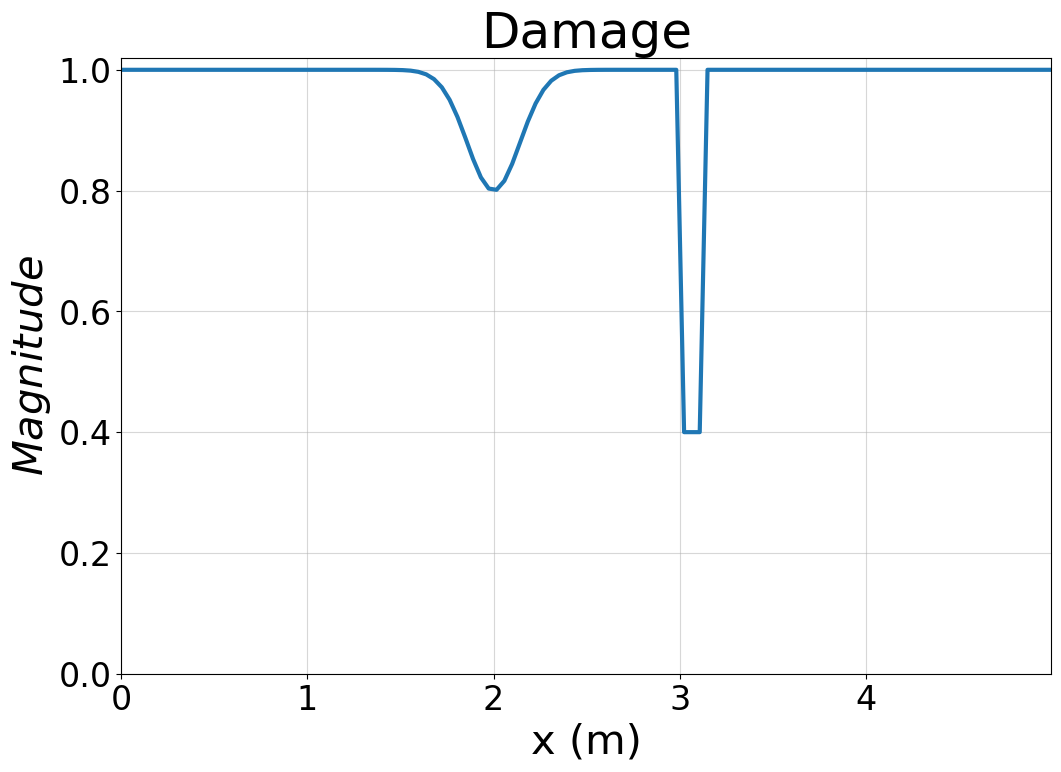

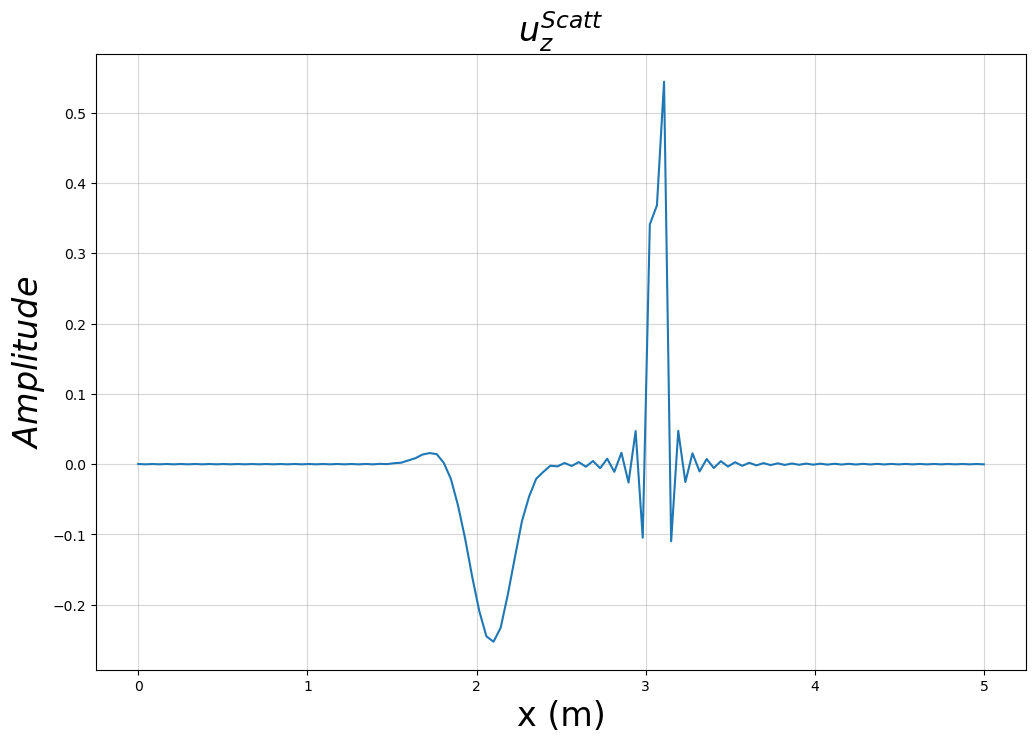

C:\ProgramData\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


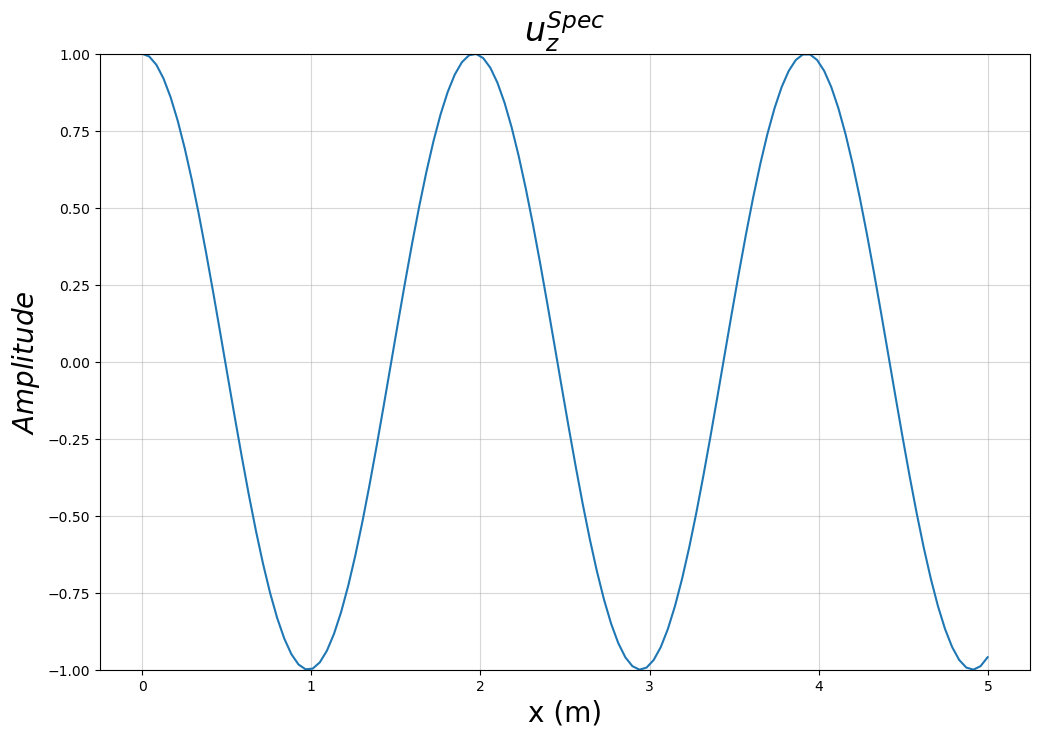

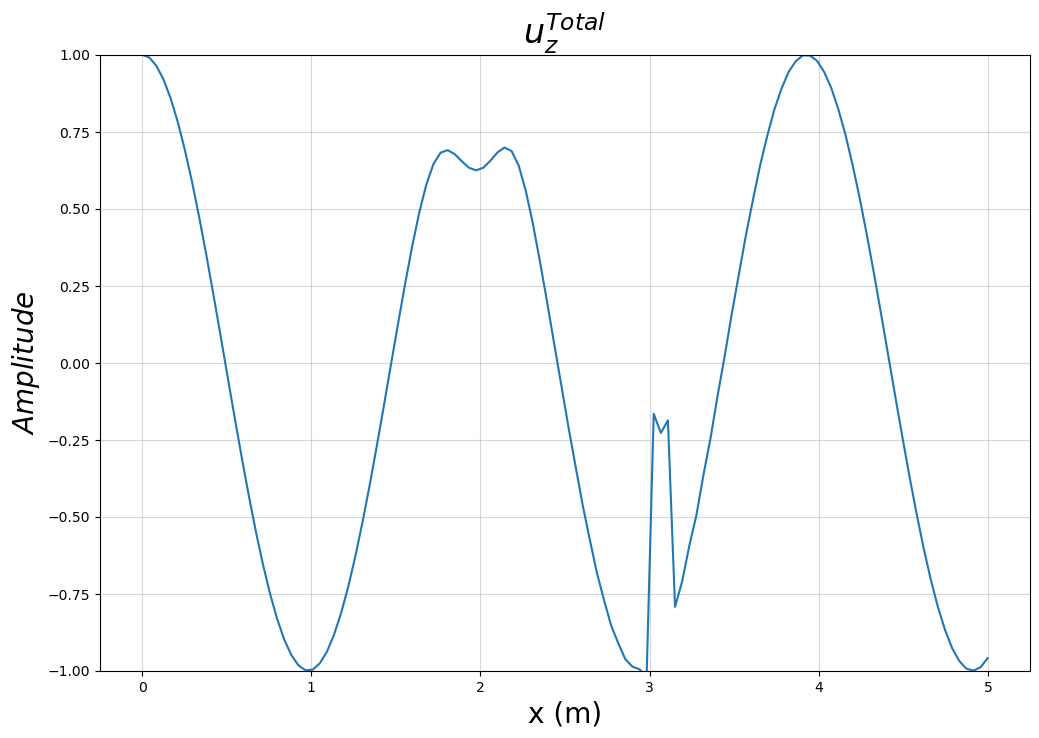

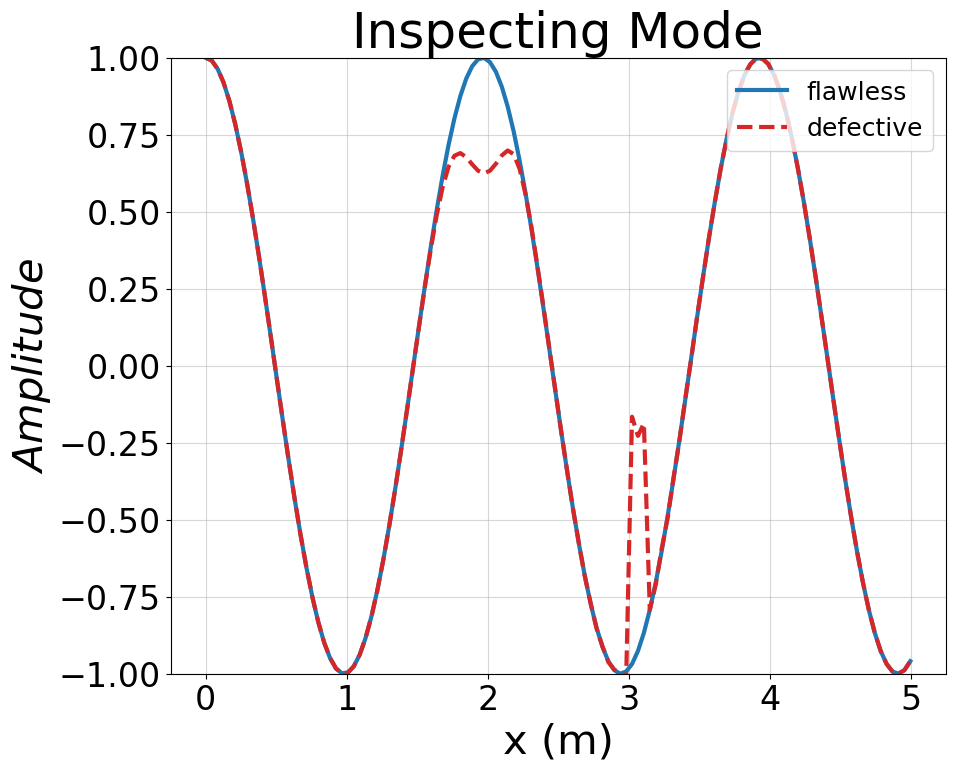

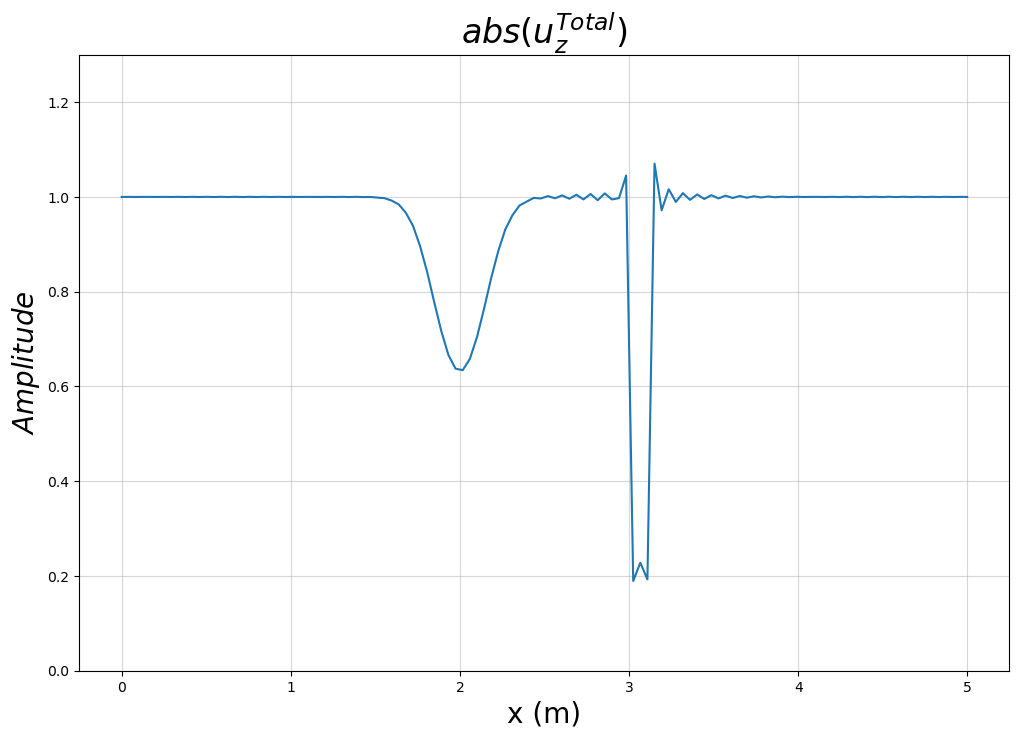

In [338]:
u_spec = u_1_spec + u_2_spec
u_total = u_spec + u_solution

plt.figure(figsize = (10, 8))
plt.figure(figsize=(12, 8))
plt.plot(x, damage, 'C0', linewidth=3)
plt.grid(alpha=0.5)
plt.xlabel('x (m)', size=30)
plt.ylabel('$Magnitude$', size=30)
plt.title('Damage', size=36)
plt.tick_params(labelsize=24)
plt.ylim([0, 1.02])
plt.xlim([x[0], x[-1]])
plt.savefig("damage_example.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(x, np.imag(u_solution[2, :]))
plt.grid(alpha=0.5)
plt.xlabel('x (m)', size=24)
plt.ylabel('$Amplitude$', size=24)
plt.title('$u_z^{Scatt}$', size=24)
#plt.ylim([-1, 1])
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(x, u_spec[2, :])
plt.grid(alpha=0.5)
plt.xlabel('x (m)', size=20)
plt.ylabel('$Amplitude$', size=20)
plt.title('$u_z^{Spec}$', size=24)
plt.ylim([-1, 1])
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(x, u_total[2, :])
plt.grid(alpha=0.5)
plt.xlabel('x (m)', size=20)
plt.ylabel('$Amplitude$', size=20)
plt.title('$u_z^{Total}$', size=24)
plt.ylim([-1, 1])
plt.show()

plt.figure(figsize = (10, 8))
plt.plot(x, u_spec[2, :],'C0', linewidth=3, label='flawless')
plt.plot(x, u_total[2, :], '--C3', linewidth=3, label='defective')
plt.grid(alpha=0.5)
plt.tick_params(labelsize=24)
plt.xlabel('x (m)', size=30)
plt.ylabel('$Amplitude$', size=30)
plt.title('Inspecting Mode', size=36)
plt.legend(fontsize=18, loc=1)
plt.ylim([-1, 1])
plt.savefig("inspection_example.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(x, np.abs(u_total[2, :]))
plt.grid(alpha=0.5)
plt.xlabel('x (m)', size=20)
plt.ylabel('$Amplitude$', size=20)
plt.title('$abs(u_z^{Total})$', size=24)
plt.ylim([0, 1.3])
plt.show()

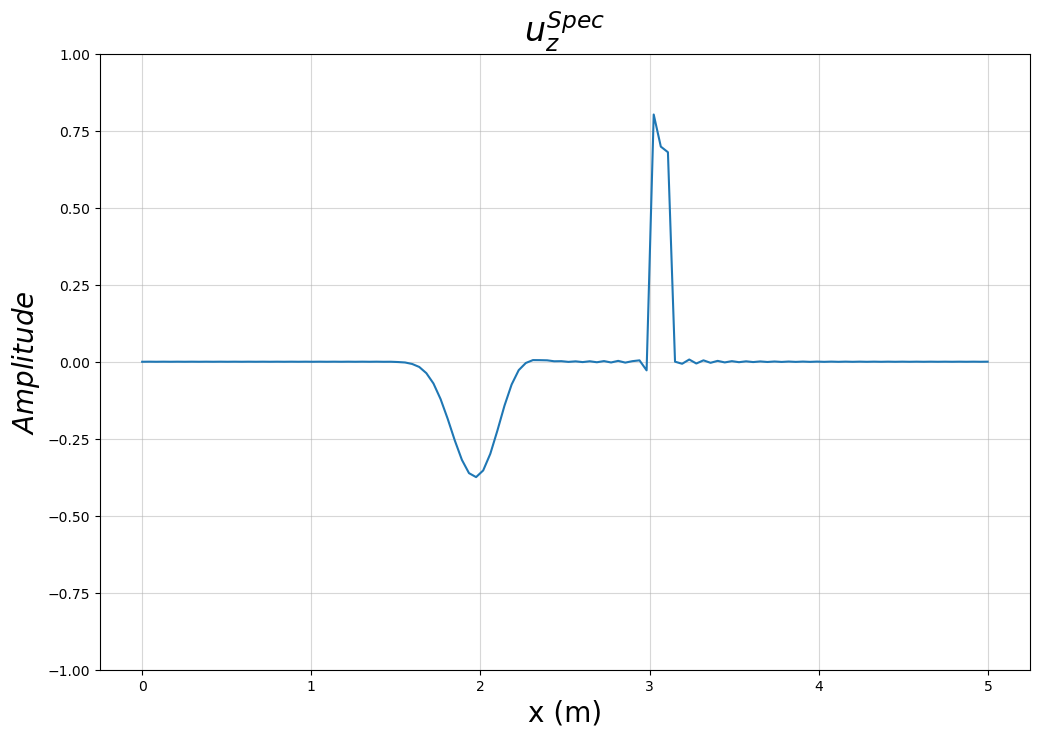

In [321]:
plt.figure(figsize = (12, 8))
plt.plot(x, u_solution[2, :])
plt.grid(alpha=0.5)
plt.xlabel('x (m)', size=20)
plt.ylabel('$Amplitude$', size=20)
plt.title('$u_z^{Spec}$', size=24)
plt.ylim([-1, 1])
plt.show()

12. #### Verifying the new residual vector:

In [316]:
u_up_top_3_fft = u_up_solution_fft

u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_down_top_3_fft[:, ii] = -np.dot(np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]), u_up_top_3_fft[:, ii])
    
u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
    u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])

u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    t_bottom_3_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
    )

u_bottom_3 = np.array(
    [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
)
t_bottom_3 = np.array(
    [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
)

K_3 = np.zeros((3, 3, nx))
for ii in range(K_3.shape[0]):
    K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_top_2[:, ii] = np.dot(
        np.linalg.inv(K_3[:, :, ii]),
        (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
    ) + u_bottom_3[:, ii]

u_top_2_fft = np.array(
    [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
)

u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_up_top_2_fft[:, ii] = -np.dot(
        np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
        (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

    )
    u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]

u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
    u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])

u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    t_bottom_2_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
    )

u_bottom_2 = np.array(
    [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
)
t_bottom_2 = np.array(
    [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
)

K_2 = np.zeros((3, 3, nx))
for ii in range(K_3.shape[0]):
    K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_top_1[:, ii] = np.dot(
        np.linalg.inv(K_2[:, :, ii]),
        (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
    ) + u_bottom_2[:, ii]

u_top_1_fft = np.array(
    [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
)

u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    u_up_top_1_fft[:, ii] = -np.dot(
        np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
        (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

    )
    u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]
    
u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
    u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])
    
t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

for ii in range(nkx):
    t_bottom_1_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
    )

new_residual_vector = np.zeros((4*nkx, 1), dtype = complex)
new_residual_aux1 = t_bottom_1_fft[0, :]
new_residual_aux3 = t_bottom_1_fft[2, :]
cont = 0

for ii in range(0, nkx):

    new_residual_vector[cont, 0] = np.real(new_residual_aux1[ii])
    new_residual_vector[cont+1, 0] = np.real(new_residual_aux3[ii])
    new_residual_vector[cont+2, 0] = np.imag(new_residual_aux1[ii])
    new_residual_vector[cont+3, 0] = np.imag(new_residual_aux3[ii])
    cont += 4

cost_function_final = np.dot(new_residual_vector.T, new_residual_vector)
print(f'cost function final value = {cost_function_final[0][0]}')

cost function final value = (7.170756134147656e-24+0j)


> #### As one can notice, the optimization procedure was able to reduce the cost function to a value very close to 0!

In [318]:
# Verifying first boundary condition:
t_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    t_top_3_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_3[:, :, ii], u_up_top_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_top_3_fft[:, ii])
    )
    
print(f'interface IV - verifying: \n traction at top = 0')
print(f'{np.max(np.abs(t_top_3_fft))}')
    
# Verifying the second boundary condition:
t_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
for ii in range(nkx):
    t_top_2_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_2[:, :, ii], u_up_top_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_top_2_fft[:, ii])
    )
    
t_top_2 = np.array(
    [np.fft.ifft(np.fft.ifftshift(t_top_2_fft[dim, :])) for dim in range(t_top_2_fft.shape[0])], dtype = complex
)

print(f'interface III - verifying: \n t_minus - t_plus = 0')
print(f'{np.max(np.abs(t_top_2-t_bottom_3))}')

# Verifying the third boundary condition:
t_top_1_fft = np.zeros(u_up_top_1_fft.shape, dtype = complex)
for ii in range(nkx):
    t_top_1_fft[:, ii] = -1j*omega*(
        np.dot(Z_up_1[:, :, ii], u_up_top_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_top_1_fft[:, ii])
    )
t_top_1 = np.array(
    [np.fft.ifft(np.fft.ifftshift(t_top_1_fft[dim, :])) for dim in range(t_top_1_fft.shape[0])], dtype = complex
)
t_bottom_2 = np.array(
    [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])], dtype = complex
)
print(f'interface II - verifying: \n t_minus - t_plus = 0')
print(f'{(np.max(np.abs(t_top_1-t_bottom_2)))}')

# Verifying the fourth boundary condition:
print(f'interface I - verifying: \n traction at bottom = 0')
print(f'{np.max(np.abs(t_bottom_1_fft))}')

interface IV - verifying: 
 traction at top = 0
4.138844734904836e-15
interface III - verifying: 
 t_minus - t_plus = 0
3.563454081952661e-12
interface II - verifying: 
 t_minus - t_plus = 0
8.204337737871924e-13
interface I - verifying: 
 traction at bottom = 0
6.936389279130784e-13
